In [316]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [317]:
dff = pd.read_csv('bmi.csv')

In [318]:
dff.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [319]:
df = dff.copy()

In [320]:
df.dtypes

Gender    object
Height     int64
Weight     int64
Index      int64
dtype: object

In [321]:
df.isnull().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [322]:
df.describe() 

,Height,Weight,Index
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


no outliers.

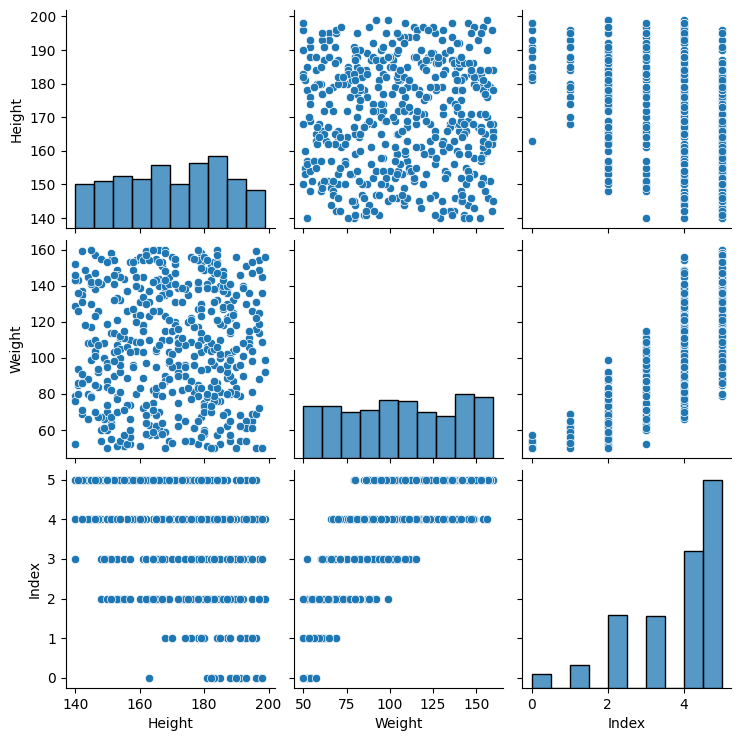

In [323]:
sns.pairplot(data = df)

In [324]:
from sklearn.preprocessing import LabelEncoder

In [325]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

In [326]:
df.head()   # male = 1, female = 0

,Gender,Height,Weight,Index
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3


In [327]:
X = df[['Gender', 'Height', 'Weight']]
y = df['Index']

In [328]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [329]:
from sklearn.model_selection import cross_val_score

In [330]:
import numpy as np

In [331]:
mse = cross_val_score(lr, X, y, scoring = 'neg_mean_squared_error', cv = 5) 
# closer to 0, the better.
print(mse)
mean_mse = np.mean(mse)
mean_mse

[-0.33824578 -0.25265203 -0.42627958 -0.26979193 -0.33536735]


np.float64(-0.3244673342567121)

In [332]:
# checking VIF (Variance Inflation factor)
# vif is useful To detect multicollinearity in Linear Regression
# VIF tells you: “Is this feature too strongly related to other features?”
# | VIF Value | Meaning                |
# | --------- | ---------------------- |
# | ≈ 1       | No correlation         |
# | 1 – 5     | Acceptable             |
# | > 5       | High multicollinearity |
# | > 10      | Serious problem        |

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [333]:
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

  Feature        VIF
0  Gender   1.940754
1  Height  11.387516
2  Weight  10.705087


High VIF values for Height and Weight shows strong multicollinearity between these two variables which makes sense because a person’s height influences their weight. Detecting such relationships helps us to understand and improve the stability of our regression models.

Linear Regression coefficients are not trustworthy. so we use ridge regression

In [334]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [335]:
from sklearn.model_selection import train_test_split

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [337]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [338]:
rr = Ridge()

In [339]:
from sklearn.linear_model import RidgeCV

In [340]:
alpha = np.logspace(-3, 3, 50)

In [341]:
ridge_cv = RidgeCV(alphas = alpha, scoring='neg_mean_squared_error', cv = 5)
ridge_cv.fit(X_train_scaled, y_train)

,"alphas alphas: array-like of shape (n_alphas,), default=(0.1, 1.0, 10.0)Array of alpha values to try.Regularization strength; must be a positive float. Regularizationimproves the conditioning of the problem and reduces the variance ofthe estimates. Larger values specify stronger regularization.Alpha corresponds to ``1 / (2C)`` in other linear models such as:class:`~sklearn.linear_model.LogisticRegression` or:class:`~sklearn.svm.LinearSVC`.If using Leave-One-Out cross-validation, alphas must be strictly positive.",array([1.0000...00000000e+03])
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto false, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"scoring scoring: str, callable, default=NoneThe scoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: negative :ref:`mean squared error ` if cv is None (i.e. when using leave-one-out cross-validation), or :ref:`coefficient of determination ` (:math:`R^2`) otherwise.",'neg_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the efficient Leave-One-Out cross-validation- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used, else,:class:`~sklearn.model_selection.KFold` is used.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",5
,"gcv_mode gcv_mode: {'auto', 'svd', 'eigen'}, default='auto'Flag indicating which strategy to use when performingLeave-One-Out Cross-Validation. Options are:: 'auto' : use 'svd' if n_samples > n_features, otherwise use 'eigen' 'svd' : force use of singular value decomposition of X when X is dense, eigenvalue decomposition of X^T.X when X is sparse. 'eigen' : force computation via eigendecomposition of X.X^TThe 'auto' mode is the default and is intended to pick the cheaperoption of the two depending on the shape of the training data.",None
,"store_cv_results store_cv_results: bool, default=FalseFlag indicating if the cross-validation values corresponding toeach alpha should be stored in the ``cv_results_`` attribute (seebelow). This flag is only compatible with ``cv=None`` (i.e. usingLeave-One-Out Cross-Validation)... versionchanged:: 1.5 Parameter name changed from `store_cv_values` to `store_cv_results`.",False
,"alpha_per_target alpha_per_target: bool, default=FalseFlag indicating whether to optimize the alpha value (picked from the`alphas` parameter list) for each target separately (for multi-outputsettings: multiple prediction targets). When set to `True`, afterfitting, the `alpha_` attribute will contain a value for each target.When set to `False`, a single alpha is used for all targets... versionadded:: 0.24",False


In [342]:
best_alpha = ridge_cv.alpha_
print(best_alpha)

0.001


In [343]:
ridge_final = Ridge(alpha=best_alpha)

In [344]:
ridge_final.fit(X_train_scaled, y_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",np.float64(0.001)
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gra

In [345]:
ridge_final.coef_

array([ 0.00655745, -0.62133479,  1.13243524])

In [346]:
ridge_pred = ridge_final.predict(X_test_scaled)

In [347]:
results = pd.DataFrame({
    'actual': y_test, 
    'predicted': ridge_pred
})
results['error'] = results['actual']-results['predicted']
results['abs_err'] = abs(results['error'])
mean_abs_error = np.mean(results['abs_err'])
print("Mean absolute error: ", mean_abs_error)
results

Mean absolute error:  0.4877202855530652


,actual,predicted,error,abs_err
361,4,3.985305,0.014695,0.014695
73,2,2.305588,-0.305588,0.305588
374,4,3.222010,0.777990,0.777990
155,4,3.298501,0.701499,0.701499
104,4,4.091891,-0.091891,0.091891
...,...,...,...,...
266,5,4.781529,0.218471,0.218471
23,5,4.332406,0.667594,0.667594
222,4,3.859320,0.140680,0.140680
261,5,4.879055,0.120945,0.120945


In [348]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [349]:
print("Variance in BMI: ", r2_score(y_test, ridge_pred))

Variance in BMI:  0.7749713794703821


In [350]:
print("mean absolute error: ", mean_absolute_error(y_test, ridge_pred))
print("mean squared error: ", mean_squared_error(y_test, ridge_pred))

mean absolute error:  0.4877202855530652
mean squared error:  0.35613529548618517


In [351]:
df.head()

,Gender,Height,Weight,Index
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3


In [352]:
gender = input("Enter Gender (male/female): ").strip().lower()

if gender == 'male':
    gender = 1
elif gender == 'female':
    gender = 0
else:
    raise ValueError("Invalid gender! Please enter 'male' or 'female'.")

height = int(input("Enter height (cm): "))
weight = int(input("Enter weight (kg): "))

In [353]:
user_data = pd.DataFrame({
    'Gender': [gender], 
    'Height': [height],
    'Weight': [weight]
})
user_data
user_data_scaled = scaler.transform(user_data)

In [354]:
predicted_bmi = ridge_final.predict(user_data_scaled)
final_result = max(0, min(5, predicted_bmi[0]))
print(f"Predicted BMI Index: {final_result:.2f}")

#  we are printing bmi in range of 0-5.

Predicted BMI Index: 2.85
